In [7]:
%cd ..

/home/dani2442/Projects


/home/dani2442/Projects/TrafficFlow/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [9]:
V_0 = 50 # Desired speed (km/h)
T = 1.2/3600 # Time gap (h)
rho_max = 120 # Maximum density (veh/km)

#V_0 = 110
#T = 1.4/3600
#rho_max = 120

l_eff = 1/rho_max # Inverse of the minimum distance headway
rho_C = 1/(V_0*T + l_eff) # Critical value between free traffic and congested traffic
C = 1/(T + l_eff/V_0)

@jax.jit
def Q_e(rho):
    return jnp.maximum(0, jnp.where(rho<=rho_C, V_0*rho, (1-rho*l_eff)/T))

In [22]:
x_0, x_N = 0, 100
N_x = 100
T_sim = 2
N_t = 1000
I = 1.0

dx = (x_N - x_0)/(N_x)
dt = T_sim/N_t

xs = jnp.linspace(x_0, x_N, N_x)
rho_0x = rho_max/4 + jnp.exp(-jnp.square((xs - x_N/2)/20))*rho_max/2
rho_t0 = rho_max/4 + jnp.zeros(N_t) 
rho_t1 = rho_max/4 + jnp.zeros(N_t) 

In [27]:
rho = np.zeros((N_t, N_x))
rho[0,:] = rho_0x
rho[:,0] = rho_t0
rho[:,-1] = rho_t1

for t_i in range(N_t-1):
    Q = I*Q_e(rho[t_i]/I)
    S = jnp.where(rho[t_i]>rho_C, Q, C)
    D = jnp.where(rho[t_i]<=rho_C, Q, C)
    Q_up = jnp.minimum(S[1:-1], D[:-2])
    Q_down = jnp.minimum(S[2:], D[1:-1])
    #rho[t_i+1,1:-1] = rho[t_i, 1:-1] + dt/dx*(Q_up - Q_down)
    rho[t_i+1,1:-1] = rho[t_i, 1:-1] + dt/dx*(Q_up - Q_down)

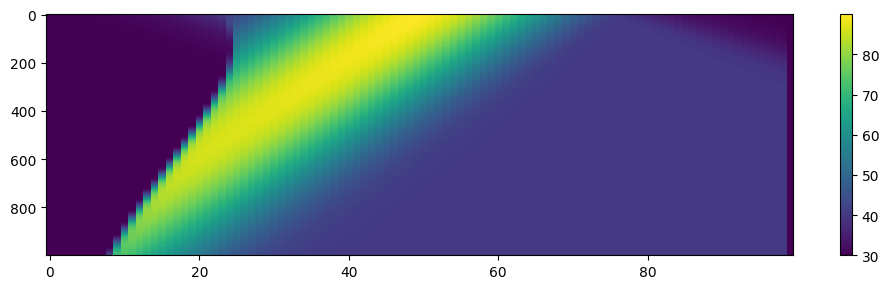

In [28]:
f, ax = plt.subplots(1, figsize=(10,3))
pos = ax.imshow(rho, aspect='auto', interpolation='none')
f.colorbar(pos, ax=ax)
plt.tight_layout()